In [2]:
import os
import glob
import shutil
from pathlib import Path
import tensorflow as tf
import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
from skimage import transform
from PIL import Image 
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
%matplotlib inline

# Data exploration and preprocessing

In [3]:
data_dir = os.walk("faces")

#checking if there are some invalid file extensions in dataset
SplitTypes = []
for walk_output in data_dir:
    for file_name in walk_output[-1]:
        SplitTypes.append(file_name.split(".")[-1])

print(set(SplitTypes)) #printing unique values

{'jpg'}


In [4]:
#dataset contains only jpg files
#creating dataset with information about sizes, ratios and classes of images

files = glob.glob("faces\\**\*.jpg")
data_info = dict()
for idx, file in enumerate(files):
    with Image.open(file) as img:
        filename = os.path.basename(file)
        width, heigth = img.size
        data_info[idx] = {'filename': filename, 'width': width, 'height': heigth,
                          'dim': img.size, 'aspect_ratio': width/heigth, 'img_class': filename[0]}

data_info = pd.DataFrame.from_dict(data_info).T
data_info.head()

,filename,width,height,dim,aspect_ratio,img_class
0,man_10005.jpg,250,250,"(250, 250)",1.0,m
1,man_10006.jpg,250,250,"(250, 250)",1.0,m
2,man_10007.jpg,250,250,"(250, 250)",1.0,m
3,man_10008.jpg,250,250,"(250, 250)",1.0,m
4,man_10009.jpg,250,250,"(250, 250)",1.0,m


In [5]:
data_info.dim.value_counts() 

(250, 250)    13226
(100, 100)    11627
(113, 147)        4
(67, 86)          4
(80, 110)         3
              ...  
(349, 487)        1
(61, 91)          1
(320, 453)        1
(224, 303)        1
(144, 173)        1
Name: dim, Length: 2125, dtype: int64

In [6]:
#there are a lot of unique sizes so lets group pictures in three classes:
#big- images equal and bigger than 250x250
#medium- images between 250x250 and 100x100 (and equal to 100x100)
#small- images smaller than 100x100

def func(row):
    if row['width'] >=250 and row['height'] >=250:
        val = 'Big'
    elif row['width'] <100 and row['height'] <100:
        val = 'Small'
    else:
        val = 'Medium'
    return val

data_info['img_size'] = data_info.apply(func, axis = 1)

#grouping images by their aspect ratio
data_info['ratio'] = np.where(data_info['aspect_ratio'] != 1, 'Not square', 'Square')

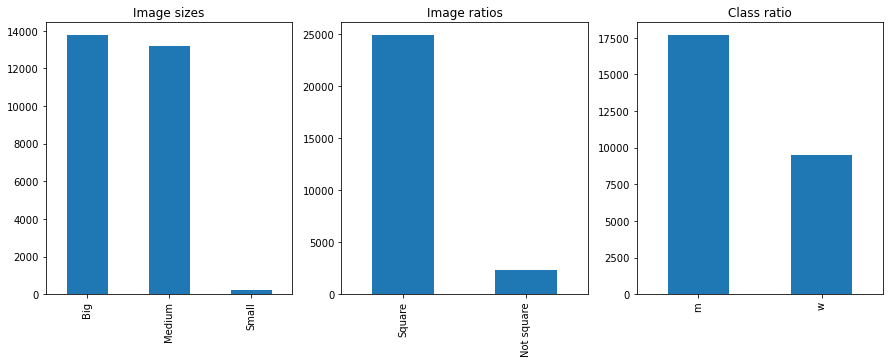

In [7]:
plt.rcParams["figure.figsize"] = (15,5)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
data_info.img_size.value_counts().plot(kind='bar',ax = ax1, title = 'Image sizes')
data_info.ratio.value_counts().plot(kind='bar',ax= ax2, title = "Image ratios")
data_info.img_class.value_counts().plot(kind='bar', ax = ax3, title = 'Class ratio')
plt.show()

In [9]:
#removing images smaller than 100x100

#list of images to remove
removeidx = np.where(data_info["img_size"]=="Small")[0].tolist()
remove = [data_info['filename'][idx] for idx in removeidx]

#new folder
data_dir = "faces"
destination_dir = "faces_cleaned"
isExist = os.path.exists(destination_dir)
if not isExist:
    shutil.copytree(data_dir, destination_dir)
    
data_dir = "faces_cleaned"

#removing images in new folder
files = glob.glob("faces_cleaned\\**\*.jpg")
for f in files:
    if os.path.basename(f) in remove:
        if isExist:
            os.remove(f)

### Dataset 1

In [10]:
batch_size = 64
image_size = (100, 100) #resizing images to 100x100

# 80/10/10 train/validation/test split, converting to grayscale and preserving aspect ratio
train_data = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, 
                                                         subset="training", seed=123, image_size=image_size, 
                                                         color_mode = "grayscale",batch_size = batch_size,
                                                         crop_to_aspect_ratio=True)

train_val_data = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, 
                                                         subset="validation", seed=123, image_size=image_size, 
                                                         color_mode = "grayscale", batch_size=None, 
                                                         crop_to_aspect_ratio=True)

test_data, val_data = tf.keras.utils.split_dataset(
                      train_val_data, left_size=0.5, shuffle=True, seed=123)

val_data = val_data.batch(batch_size = batch_size)
test_data = test_data.batch(batch_size = batch_size)

class_names = train_data.class_names

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_data).numpy())
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_data).numpy())
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_data).numpy())

Found 26941 files belonging to 2 classes.
Using 21553 files for training.
Found 26941 files belonging to 2 classes.
Using 5388 files for validation.
Number of training batches: 337
Number of validation batches: 43
Number of test batches: 43


In [12]:
#checking class distribution in train set
count = np.zeros(2, dtype=np.int32)
for _, labels in train_data:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()
n = count[0]+count[1]
print("Class distribution in train set:\n man:",round(count[0]/n,2),"woman:",round(count[1]/n,2))


#dataset is highly imbalanced
#performing resampling to balance out classes in train set
def class_func(features, label):
    return label

train_data_balanced = train_data.unbatch().rejection_resample(
                      class_func, target_dist=[0.5, 0.5])
train_data_balanced = train_data_balanced.batch(batch_size)
train_data_balanced= train_data_balanced.map(lambda extra_label, features_and_label: features_and_label)

#distribution after resampling
count = np.zeros(2, dtype=np.int32)
for _, labels in train_data_balanced:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()
n = count[0]+count[1]
print("Class distribution in train set after resampling:\n man:",round(count[0]/n,2),"woman:",round(count[1]/n,2))

Class distribution in train set:
 man: 0.65 woman: 0.35
Class distribution in train set after resampling:
 man: 0.5 woman: 0.5


In [13]:
#checking pixels values and img shape
image_batch, labels_batch = next(iter(train_data_balanced))
first_image = image_batch[0]
print('Before normalization:')
print('min:',np.min(first_image))
print('max:', np.max(first_image))
print('Image shape:',first_image.shape)

#normalization for faster convergence
preprocess = tf.keras.layers.Rescaling(1./255)

train_data_clean = train_data_balanced.map(
  lambda x, y: (preprocess(x, training=True), y))
val_data = val_data.map(
  lambda x, y: (preprocess(x, training=True), y))
test_data = test_data.map(
  lambda x, y: (preprocess(x, training=True), y))

image_batch, labels_batch = next(iter(train_data_clean))
first_image = image_batch[0]
print('\nAfter normalization:')
print('min:',np.min(first_image))
print('max:', np.max(first_image))
print('Image shape:',first_image.shape)

Before normalization:
min: 8.0
max: 226.0
Image shape: (100, 100, 1)

After normalization:
min: 0.0
max: 0.98823535
Image shape: (100, 100, 1)


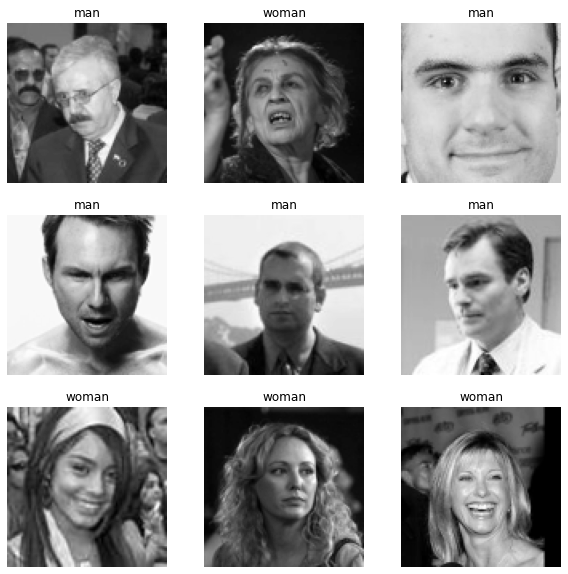

In [14]:
#visualizing how dataset looks like
plt.figure(figsize=(10, 10))
for images, labels in train_data_clean.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy(), cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")

###  Dataset 2

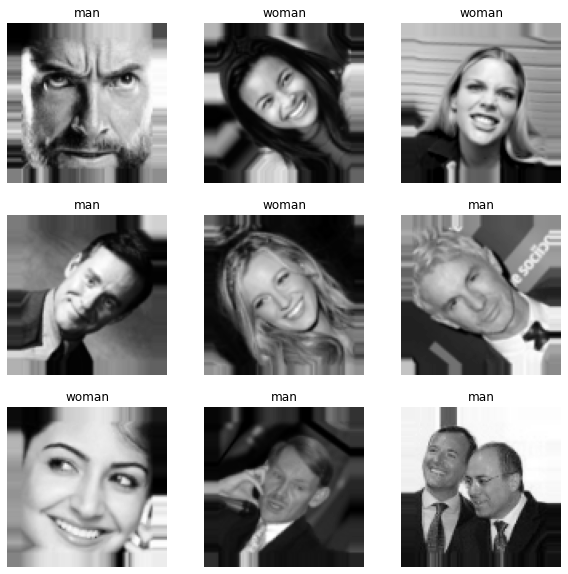

In [15]:
#randomly rotating, zooming and fliping horizontaly
#randomly changing brightness and contrast of the photos
preprocess = tf.keras.Sequential([
                   layers.RandomRotation(0.15),
                   layers.RandomZoom(height_factor= (.2, .1),
                                    fill_mode = 'nearest'),
                   layers.RandomFlip("horizontal"),
                   layers.RandomContrast(0.3),
                   layers.RandomBrightness(0.001)
                ])


train_data_clean2 = train_data_clean.map(
  lambda x, y: (preprocess(x, training=True), y))

plt.figure(figsize=(10, 10))
for images, labels in train_data_clean2.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy(), cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Training

In [21]:
def model_history(model, train_data, val_data): #function for training purposes
    
    #setting Early Stopping callback: training will stop if validation loss doesn't improve after 3 epochs
    callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)
    #training
    history = model.fit(train_data,
          batch_size=batch_size,
          epochs=20,
          validation_data=val_data,
          callbacks = callback)

    #plotting loss curve
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def model_evaluate(model, y_true, test_data): #function for evaluation 
    
    #getting predicted classes
    pred_class = (model.predict(test_data) > 0.5).astype("int32")
    pred_class = [item for sublist in pred_class for item in sublist]
    
    #confusion matrix
    cm = confusion_matrix(true_class.tolist(), pred_class, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0,1])
    disp.plot()

    results = model.evaluate(test_data)
    print("Evaluation on test set:")
    print("Accuracy:", results[1])
    print("Loss:", results[0])

#extracting correct classes from test data    
images, labels = tuple(zip(*test_data.unbatch()))
true_class = np.array(labels)


AUTOTUNE = tf.data.AUTOTUNE
train_data_clean = train_data_clean.cache().prefetch(buffer_size=AUTOTUNE)
train_data_clean2 = train_data_clean2.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

#setting seed for consistency of training
tf.random.set_seed(123)

### Models

In [24]:
#CNN MODELS
#architecture of first CNN model:
#input layer with 32 filters 5x5 kernel size + reLU activation
#two hidden convolutional layers, each followed by Max Pooling with 2x2 filter size and dropout + reLU activation
#fully connected hidden layer with 100 units + reLU activation
#output layer with sigmoid activation 
model1_CNN = keras.models.Sequential([
             keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape = [100, 100, 1]),
             keras.layers.AveragePooling2D(2,2),
             keras.layers.Conv2D(64, (3, 3), activation='relu'),
             keras.layers.AveragePooling2D(2,2),
             keras.layers.Dropout(0.6),
             keras.layers.Conv2D(64, (3, 3), activation='relu'),
             keras.layers.AveragePooling2D(2,2),
             keras.layers.Dropout(0.5),
             keras.layers.Flatten(),
             keras.layers.Dense(100, activation='relu'),
             keras.layers.Dense(1, activation ='sigmoid')
             ])

#second CNN model has only one hidden convolutional layer, besides this, its architecture is same as the first one
model2_CNN = keras.models.Sequential([
             keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape = [100, 100, 1]),
             keras.layers.AveragePooling2D(2,2),
             keras.layers.Conv2D(64, (3, 3), activation='relu'),
             keras.layers.AveragePooling2D(2,2),
             keras.layers.Dropout(0.5),
             keras.layers.Flatten(),
             keras.layers.Dense(100, activation='relu'),
             keras.layers.Dense(1, activation ='sigmoid')
             ])



#NN MODELS
#to fit images into NN model without convolution we first need to flatten our input to 1D

#first NN model consists of:
#non-trainable flatten layer (to fit images into NN model without convolution we first need to flatten our input to 1D)
#input layer with 300 nodes
#three hidden fully connected layers with 100 nodes, each followed by dropout
#output layer with sigmoid activation
model1_NN = keras.models.Sequential([keras.layers.Flatten(input_shape = [100, 100]),
            keras.layers.Dense(300, activation = 'relu' ),
            keras.layers.Dense(100, activation = 'relu' ),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(100, activation = 'relu' ),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(100, activation = 'relu' ),
            keras.layers.Dropout(0.2) ,                   
            keras.layers.Dense(1, activation = 'sigmoid' )])

#second model has only one hidden layer followed by dropout
model2_NN = keras.models.Sequential([keras.layers.Flatten(input_shape = [100, 100]),
            keras.layers.Dense(300, activation = 'relu' ),
            keras.layers.Dense(200, activation = 'relu' ),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(1, activation = 'sigmoid' )])



#KNN MODELS

model1_KNN=KNeighborsClassifier(n_neighbors=7) 
model2_KNN=KNeighborsClassifier(n_neighbors=10) 

## Dataset 1

### CNN

In [25]:
model1_CNN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model1_CNN, train_data_clean, val_data)
model_evaluate(model1_CNN, true_class, test_data)

Epoch 1/20
337/337 [==============================] - 99s 288ms/step - loss: 0.5888 - binary_accuracy: 0.6696 - val_loss: 0.4920 - val_binary_accuracy: 0.7591
Epoch 2/20
337/337 [==============================] - 94s 279ms/step - loss: 0.4716 - binary_accuracy: 0.7733 - val_loss: 0.4321 - val_binary_accuracy: 0.7944
Epoch 3/20
337/337 [==============================] - 95s 282ms/step - loss: 0.4108 - binary_accuracy: 0.8088 - val_loss: 0.3747 - val_binary_accuracy: 0.8344
Epoch 4/20
337/337 [==============================] - 96s 284ms/step - loss: 0.3650 - binary_accuracy: 0.8322 - val_loss: 0.3404 - val_binary_accuracy: 0.8493
Epoch 5/20
337/337 [==============================] - 95s 283ms/step - loss: 0.3310 - binary_accuracy: 0.8514 - val_loss: 0.3215 - val_binary_accuracy: 0.8575
Epoch 6/20
337/337 [==============================] - 97s 287ms/step - loss: 0.3096 - binary_accuracy: 0.8629 - val_loss: 0.3222 - val_binary_accuracy: 0.8589
Epoch 7/20
337/337 [==========================

KeyboardInterrupt: 

In [ ]:
model1_CNN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])


model_history(model1_CNN, train_data_clean, val_data)
model_evaluate(model1_CNN, true_class, test_data)

In [ ]:
model2_CNN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=['accuracy'])


model_history(model2_CNN, train_data_clean, val_data)
model_evaluate(model2_CNN, true_class, test_data)

In [ ]:
model2_CNN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model2_CNN, train_data_clean, val_data)
model_evaluate(model2_CNN, true_class, test_data)

### Simple neural network

In [30]:
model1_NN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model1_NN, train_data_clean, val_data)
model_evaluate(model1_NN, true_class, test_data)

Epoch 1/25
337/337 [==============================] - 158s 446ms/step - loss: 0.6554 - accuracy: 0.6520 - val_loss: 0.5284 - val_accuracy: 0.7450
Epoch 2/25
 44/337 [==>...........................] - ETA: 2:20 - loss: 0.5687 - accuracy: 0.7085

KeyboardInterrupt: 

Epoch 1/25
337/337 [==============================] - 117s 323ms/step - loss: 0.5161 - accuracy: 0.4990 - val_loss: 0.5193 - val_accuracy: 0.3556
Epoch 2/25
337/337 [==============================] - 79s 218ms/step - loss: 0.5116 - accuracy: 0.4972 - val_loss: 0.5444 - val_accuracy: 0.3556
Epoch 3/25
337/337 [==============================] - 78s 220ms/step - loss: 0.5082 - accuracy: 0.4992 - val_loss: 0.5237 - val_accuracy: 0.3556
Epoch 4/25
337/337 [==============================] - 76s 215ms/step - loss: 0.5068 - accuracy: 0.4998 - val_loss: 0.5144 - val_accuracy: 0.3556
Epoch 5/25
337/337 [==============================] - 82s 232ms/step - loss: 0.5053 - accuracy: 0.4981 - val_loss: 0.5272 - val_accuracy: 0.3556
Epoch 6/25
337/337 [==============================] - 75s 211ms/step - loss: 0.5029 - accuracy: 0.4991 - val_loss: 0.5416 - val_accuracy: 0.3556
Epoch 7/25
337/337 [==============================] - 72s 204ms/step - loss: 0.4998 - accuracy: 0.4999 - val_loss: 0.5235 - val_a

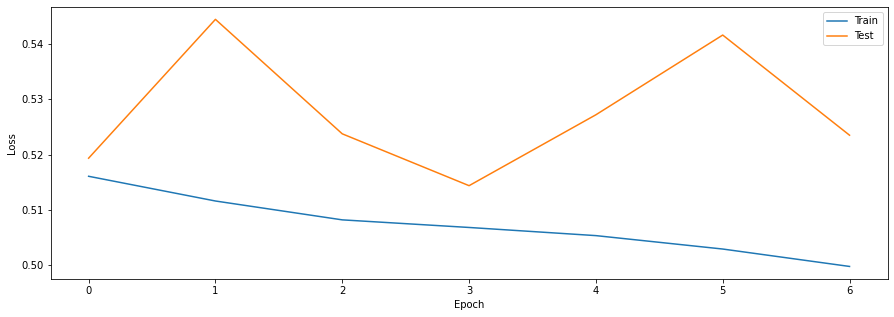

43/43 [==============================] - 1s 12ms/step - loss: 0.5223 - accuracy: 0.3541
Evaluation on test set:
Accuracy: 0.35412025451660156
Loss: 0.5222647190093994


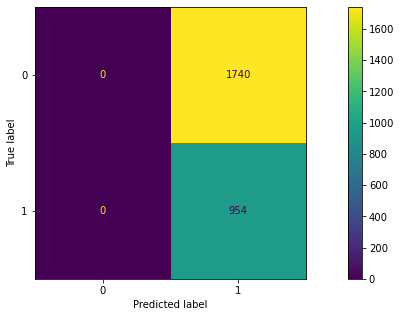

In [53]:
model1_NN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model1_NN, train_data_clean, val_data)
model_evaluate(model1_NN, true_class, test_data)

In [54]:
model2_NN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model2_NN, train_data_clean, val_data)
model_evaluate(model2_NN, true_class, test_data)

Epoch 1/25
337/337 [==============================] - 80s 224ms/step - loss: 0.6445 - accuracy: 0.4988 - val_loss: 0.6418 - val_accuracy: 0.3556
Epoch 2/25
337/337 [==============================] - 82s 231ms/step - loss: 0.5621 - accuracy: 0.4988 - val_loss: 0.6403 - val_accuracy: 0.3556
Epoch 3/25
337/337 [==============================] - 86s 246ms/step - loss: 0.5407 - accuracy: 0.4990 - val_loss: 0.5021 - val_accuracy: 0.3556
Epoch 4/25
 66/337 [====>.........................] - ETA: 1:24 - loss: 0.5259 - accuracy: 0.5005

KeyboardInterrupt: 

In [ ]:
model2_NN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])


model_history(model2_NN, train_data_clean, val_data)
model_evaluate(model2_NN, true_class, test_data)

### KNN

In [32]:
#processing tf dataset to fit into KNN model

images, labels = tuple(zip(*train_data_clean.unbatch()))
images = np.array(images)
y_train = np.array(labels)
nsamples, nx, ny, nrgb = images.shape
x_train = images.reshape((nsamples,nx*ny*nrgb)) #reshaping from 4D to 2D
print("Train set:")
print("Before reshaping:",images.shape)
print("After reshaping:",x_train.shape)

images, labels = tuple(zip(*test_data.unbatch()))
images = np.array(images)
y_test = np.array(labels)
nsamples, nx, ny, nrgb = images.shape
x_test = images.reshape((nsamples,nx*ny*nrgb)) #reshaping from 4D to 2D
print("Test set:")
print("Before reshaping:",images.shape)
print("After reshaping:",x_test.shape)

Train set:
Before reshaping: (21568, 96, 96, 1)
After reshaping: (21568, 9216)
Test set:
Before reshaping: (2694, 96, 96, 1)
After reshaping: (2694, 9216)


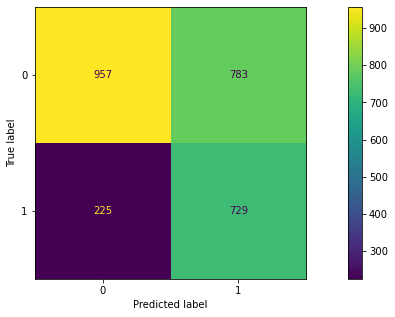

In [34]:
model1_KNN=KNeighborsClassifier(n_neighbors=7)
model2_KNN=KNeighborsClassifier(n_neighbors=7)

KNN.fit(x_train,y_train)
y_pred_KNN=KNN.predict(x_test)


cm = confusion_matrix(y_test, y_pred_KNN, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0,1])

print(classification_report(y_pred_KNN,y_test))
disp.plot()

## Dataset 2 (augumented)

### CNN

In [34]:
model1_CNN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model1_CNN, train_data_clean2, val_data)
model_evaluate(model1_CNN, true_class, test_data)

Epoch 1/25
337/337 [==============================] - 185s 530ms/step - loss: 0.6025 - binary_accuracy: 0.6672 - val_loss: 0.5844 - val_binary_accuracy: 0.6793
Epoch 2/25
337/337 [==============================] - 111s 328ms/step - loss: 0.4891 - binary_accuracy: 0.7583 - val_loss: 0.5346 - val_binary_accuracy: 0.7149
Epoch 3/25
337/337 [==============================] - 110s 327ms/step - loss: 0.4103 - binary_accuracy: 0.8031 - val_loss: 0.5186 - val_binary_accuracy: 0.7402
Epoch 4/25
337/337 [==============================] - 109s 322ms/step - loss: 0.3468 - binary_accuracy: 0.8402 - val_loss: 0.5737 - val_binary_accuracy: 0.7249
Epoch 5/25
337/337 [==============================] - 112s 331ms/step - loss: 0.2885 - binary_accuracy: 0.8698 - val_loss: 0.6982 - val_binary_accuracy: 0.7008
Epoch 6/25
337/337 [==============================] - 115s 342ms/step - loss: 0.2333 - binary_accuracy: 0.8996 - val_loss: 0.8491 - val_binary_accuracy: 0.6934
Epoch 7/25
147/337 [============>.......

KeyboardInterrupt: 

In [ ]:
model1_CNN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model1_CNN, train_data_clean2, val_data)
model_evaluate(model1_CNN, true_class, test_data)

In [ ]:
model2_CNN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model2_CNN, train_data_clean2, val_data)
model_evaluate(model2_CNN, true_class, test_data)

In [ ]:
model2_CNN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model2_CNN, train_data_clean2, val_data)
model_evaluate(model2_CNN, true_class, test_data)

### Simple neural network

In [ ]:
model1_NN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model1_NN, train_data_clean2, val_data)
model_evaluate(model1_NN, true_class, test_data)

In [ ]:
model1_NN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model1_NN, train_data_clean2, val_data)
model_evaluate(model1_NN, true_class, test_data)

In [ ]:
model2_NN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model2_NN, train_data_clean2, val_data)
model_evaluate(model2_NN, true_class, test_data)

In [ ]:
model2_NN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model2_NN, train_data_clean2, val_data)
model_evaluate(model2_NN, true_class, test_data)

### KNN

In [35]:
images, labels = tuple(zip(*train_data_clean2.unbatch()))
images = np.array(images)
y_train = np.array(labels)
nsamples, nx, ny, nrgb = images.shape
x_train = images.reshape((nsamples,nx*ny*nrgb)) #reshaping from 4D to 2D
print("Train set:")
print("Before reshaping:",images.shape)
print("After reshaping:",x_train.shape)

images, labels = tuple(zip(*test_data.unbatch()))
images = np.array(images)
y_test = np.array(labels)
nsamples, nx, ny, nrgb = images.shape
x_test = images.reshape((nsamples,nx*ny*nrgb)) #reshaping from 4D to 2D
print("Test set:")
print("Before reshaping:",images.shape)
print("After reshaping:",x_test.shape)

NameError: name 'train_data_clean2' is not defined

In [ ]:
KNN=KNeighborsClassifier(n_neighbors=7)

KNN.fit(x_train,y_train)
y_pred_KNN=KNN.predict(x_test)


cm = confusion_matrix(y_test, y_pred_KNN, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0,1])

print(classification_report(y_pred_KNN,y_test))
disp.plot()